In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import random

In [4]:
# load data
# each of the data files consists of records (lines), each record (line) contains 257 values
# the first value is the label (0-9), the rest are pixel values between -1 and 1
data = np.loadtxt('zipcombo.dat')
train_data = np.loadtxt('zipcombo.dat', usecols=range(1, 257))

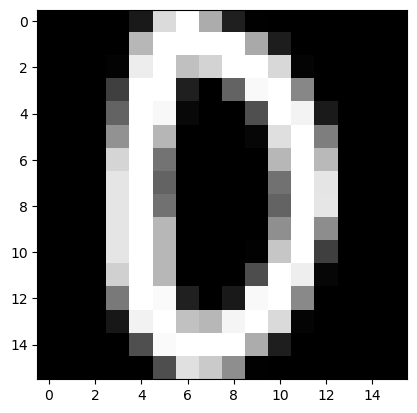

In [62]:
# plot the data
id = random.sample(range(0, len(data)), 1)
fig, ax = plt.subplots(1, 1)
ax.imshow(data[id, 1:].reshape(16, 16), cmap='gray')
plt.show()

In [90]:
# Polynomial Kernel
def polynomial_kernel(x, y, degree=3):
    return (np.dot(x, y.T)) ** degree

def gaussian_kernel(p, q, k):
    p_norm = np.sum(p**2, axis =-1)
    q_norm = np.sum(q**2, axis =-1)
    return np.exp(-k*(p_norm[:, None] + q_norm[None,:]-2*(p @ q.T)))

In [28]:

# Polynomial Kernel
def polynomial_kernel(x, y, degree=3):
    return (np.dot(x, y.T)) ** degree

# Gaussian Kernel
# def gaussian_kernel(x, y, c):
#     return np.exp(-c * np.linalg.norm(x - y) ** 2)

# # voting function
# def voting(predictions):
#     return np.argmax(np.bincount(predictions))


# train test split: return x_train, x_test, y_train, y_test
def train_test_split(dataset, ratio=0.8, split_label=True):
    """
    Split the data randomly to two sets with a given ratio

    dataset: nparray
    ratio: float = train/whole
    """
    # shuffle the dataset
    # np.random.shuffle(dataset)
    # get expected size of train_Set
    train_size = int(ratio * len(dataset))

    train = dataset[:train_size]
    test = dataset[train_size:]

    # sometimes dont want to split the data and label
    if not split_label:
        return train, test

    x_train = train[:, 1:]
    y_train = train[:, 0]
    x_test = test[:, 1:]
    y_test = test[:, 0]
    return x_train, y_train, x_test, y_test

# One-vs-Rest Perceptron

class OneVsRestPerceptron():
    def __init__(self, X, Y, kernel=polynomial_kernel, degree=3, number_of_classes=10):
        self.X = X
        self.Y = Y
        self.feature_size = X.shape[1]
        self.data_size = X.shape[0]
        self.number_of_classes = number_of_classes
        self.kernel = kernel
        self.degree = degree
        self.weights = np.zeros((number_of_classes, self.data_size))

    def train(self, max_epochs=20, optimal_epochs=None):
        # compute the kernel function
        kernel_function = self.kernel(self.X, self.X, self.degree)
        # randomize the order of the data
        id = np.arange(self.data_size)
        np.random.shuffle(id)

        mean_error = []
        if not optimal_epochs:
            for epoch in range(max_epochs):
                error = 0

                for i in id:
                    # compute the prediction
                    prediction = int(np.argmax(np.dot(self.weights, kernel_function[i,:])))

                    # update the weights
                    if prediction != self.Y[i]:
                        self.weights[int(self.Y[i]), i] += 1
                        self.weights[prediction, i] -= 1
                        error += 1
                mean_error.append(error / self.data_size)
                print(f'Epoch {epoch + 1}/{max_epochs}, error {error / self.data_size}')
                # break condition
                if epoch > 1 and np.absolute(mean_error[-2] - mean_error[-1]) < 1e-5:
                    optimal_epochs = epoch + 1
                    break

        if optimal_epochs:
            for epoch in range(optimal_epochs):
                error = 0
                for i in id:
                    prediction = int(np.argmax(np.dot(self.weights, kernel_function[i,:])))
                    if prediction != self.Y[i]:
                        self.weights[int(self.Y[i]), i] += 1
                        self.weights[prediction, i] -= 1
                        error += 1
                mean_error.append(error / self.data_size)
                print(f'Epoch {epoch + 1}/{max_epochs}, error {error / self.data_size}')

        return self.weights, mean_error
    
    def predict(self, X_test):
        # compute the kernel function
        kernel_function = self.kernel(X_test, self.X, self.degree)
        # compute the prediction
        predictions = np.argmax(np.dot(self.weights, kernel_function.T), axis=0)
        return predictions
    
    def test(self, X_test, Y_test):
        # compute the error
        kernel = self.kernel(self.X, X_test, self.degree).T

        error = 0
        for i in range(X_test.shape[0]):
            prediction = int(np.argmax(np.dot(self.weights, kernel[i,:])))
            if prediction != Y_test[i]:
                error += 1
        return error / X_test.shape[0]
    
    def confusion_matrix(self, X_test, Y_test):
        # compute the error
        kernel = self.kernel(self.X, X_test, self.degree).T

        confusion_matrix = np.zeros((self.number_of_classes, self.number_of_classes))
        for i in range(X_test.shape[0]):
            prediction = int(np.argmax(np.dot(self.weights, kernel[int(i)])))
            if prediction != Y_test[i]:
                confusion_matrix[int(Y_test[i]), prediction] += 1
        # normalize the confusion matrix
        confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1, keepdims=True)
        # handle the case of division by zero
        confusion_matrix = np.nan_to_num(confusion_matrix)
        return confusion_matrix


Epoch 1/20, error 0.09317020704490454
Epoch 2/20, error 0.02648561441247647
Epoch 3/20, error 0.01438558752352783
Epoch 4/20, error 0.007932239849421888
Epoch 5/20, error 0.007663350363000807
Epoch 6/20, error 0.004571121269158376
Epoch 7/20, error 0.0056466792148427
Epoch 8/20, error 0.0056466792148427
Epoch 1/20, error 0.0029577843506318905
Epoch 2/20, error 0.00282333960742135
Epoch 3/20, error 0.00282333960742135
Epoch 4/20, error 0.0016133369185264857
Epoch 5/20, error 0.0026888948642108095
Epoch 6/20, error 0.0010755579456843238
Epoch 7/20, error 0.0016133369185264857
Epoch 8/20, error 0.0018822264049475664


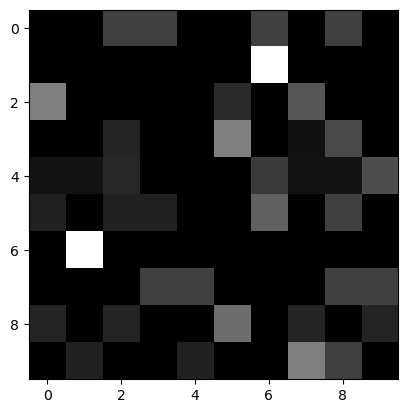

[[0.         0.         0.25       0.25       0.         0.
  0.25       0.         0.25       0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.         0.16666667
  0.         0.33333333 0.         0.        ]
 [0.         0.         0.14285714 0.         0.         0.5
  0.         0.07142857 0.28571429 0.        ]
 [0.07692308 0.07692308 0.15384615 0.         0.         0.
  0.23076923 0.07692308 0.07692308 0.30769231]
 [0.125      0.         0.125      0.125      0.         0.
  0.375      0.         0.25       0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.25       0.25       0.
  0.         0.         0.25       0.25      ]
 [0.14285714 0.         0.14285714 0.         0.         0.42857143
  0.         0.14285714 0.         0.14285714]
 [0.         0.125  

In [90]:
# test the model
X_train, Y_train, X_test, Y_test = train_test_split(data)
model = OneVsRestPerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=3)
weights, mean_error = model.train()
error = model.test(X_test, Y_test)
confusion_matrix = model.confusion_matrix(X_test, Y_test)
print(confusion_matrix)
print(f'Test error: {error}')

print(weights)

In [66]:
# Basic results
# find the optimal epoch 
train_errors = []
test_errors = []
last_run = []
for degree in range(1, 8):
    train_error = np.zeros(20)
    test_error = np.zeros(20)
    for run in range(20):
        X_train, Y_train, X_test, Y_test = train_test_split(data)
        model = OneVsRestPerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=degree)
        weights, mean_error = model.train()
        error = model.test(X_test, Y_test)
        print(f'Degree: {degree}, Test error: {error}')
        train_error[run] = mean_error[-1] 
        test_error[run] = error
        if run == 19:
            last_run.append(mean_error)
    train_errors.append(np.mean(train_error))
    test_errors.append(np.mean(test_error))




Epoch 1/20, error 0.15165367034148966
Epoch 2/20, error 0.09774132831406292
Epoch 3/20, error 0.0896746437214305
Epoch 4/20, error 0.08349018553374563
Epoch 5/20, error 0.07878461952137672
Epoch 6/20, error 0.07098682441516536
Epoch 7/20, error 0.0754235009411132
Epoch 8/20, error 0.06897015326700726
Epoch 9/20, error 0.07165904813121807
Epoch 10/20, error 0.061037913417585375
Epoch 11/20, error 0.05902124226942727
Epoch 12/20, error 0.05740790535090078
Epoch 13/20, error 0.0648023662274805
Epoch 14/20, error 0.0571390158644797
Epoch 15/20, error 0.0584834632965851
Epoch 16/20, error 0.056466792148426995
Epoch 17/20, error 0.053374563054584566
Epoch 18/20, error 0.052567894595321324
Epoch 19/20, error 0.05310567356816349
Epoch 20/20, error 0.050820112933584294
Degree: 1, Test error: 0.07580645161290323
Epoch 1/20, error 0.15299811777359507
Epoch 2/20, error 0.09841355203011562
Epoch 3/20, error 0.08362463027695617
Epoch 4/20, error 0.08026351169669266
Epoch 5/20, error 0.07125571390158

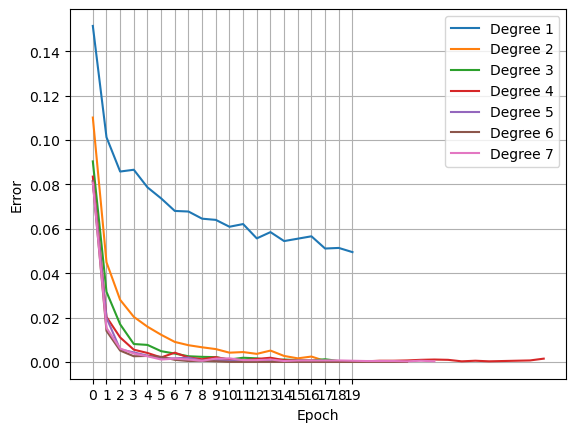

In [67]:
# plot the results in last run, to find the optimal epoch
fig, ax = plt.subplots(1, 1)
ax.plot(last_run[0], label='Degree 1')
ax.plot(last_run[1], label='Degree 2')
ax.plot(last_run[2], label='Degree 3')
ax.plot(last_run[3], label='Degree 4')
ax.plot(last_run[4], label='Degree 5')
ax.plot(last_run[5], label='Degree 6')
ax.plot(last_run[6], label='Degree 7')
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.legend()
plt.grid()
plt.xticks(range(0, 20, 1))

# save the plot
plt.savefig('polynomial_kernel.png')
plt.show()

In [68]:
# Q3 Results with optimal epoch = 13
train_errors = []
test_errors = []
for degree in range(1, 8):
    train_error = np.zeros(20)
    test_error = np.zeros(20)
    for run in range(20):
        X_train, Y_train, X_test, Y_test = train_test_split(data)
        model = OneVsRestPerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=degree)
        weights, mean_error = model.train(optimal_epochs=13)
        error = model.test(X_test, Y_test)
        print(f'Degree: {degree}, Test error: {error}')
        train_error[run] = mean_error[-1] 
        test_error[run] = error
    train_errors.append(train_error)
    test_errors.append(test_error)

Epoch 1/20, error 0.14936810970691047
Epoch 2/20, error 0.09639688088195751
Epoch 3/20, error 0.08241462758806131
Epoch 4/20, error 0.07676794837321861
Epoch 5/20, error 0.07717128260285022
Epoch 6/20, error 0.06870126378058618
Epoch 7/20, error 0.06749126109169132
Epoch 8/20, error 0.062382360849690774
Epoch 9/20, error 0.06453347674105943
Epoch 10/20, error 0.06036568970153267
Epoch 11/20, error 0.059155687012637806
Epoch 12/20, error 0.059290131755848345
Epoch 13/20, error 0.05592901317558484
Degree: 1, Test error: 0.09032258064516129
Epoch 1/20, error 0.14721699381554182
Epoch 2/20, error 0.0993546652325894
Epoch 3/20, error 0.08712019360043022
Epoch 4/20, error 0.0810701801559559
Epoch 5/20, error 0.07367571927937618
Epoch 6/20, error 0.07152460338800753
Epoch 7/20, error 0.07286905082011293
Epoch 8/20, error 0.062113471363269696
Epoch 9/20, error 0.061979026620059156
Epoch 10/20, error 0.062382360849690774
Epoch 11/20, error 0.06036568970153267
Epoch 12/20, error 0.05915568701263

In [69]:
train_errors_array = np.array(train_errors)
test_errors_array = np.array(test_errors)

train_errors_mean = np.mean(train_errors_array, axis=1)*100
train_errors_std = np.std(train_errors_array, axis=1)*100
test_errors_mean = np.mean(test_errors_array, axis=1)*100
test_errors_std = np.std(test_errors_array, axis=1)*100

# show the results in a table 
print('Degree\tTrain Error\tTest Error')
for degree in range(1, 8):
    print(f'{degree}\t{train_errors_mean[degree-1]:.4f} ± {train_errors_std[degree-1]:.4f}\t{test_errors_mean[degree-1]:.4f} ± {test_errors_std[degree-1]:.4f}')
# save the table




Degree	Train Error	Test Error
1	5.9956 ± 0.2860	8.4919 ± 0.8702
2	0.3892 ± 0.1252	3.8495 ± 0.5200
3	0.1721 ± 0.0682	3.2581 ± 0.4121
4	0.0672 ± 0.0348	3.1559 ± 0.5430
5	0.0733 ± 0.0570	3.0753 ± 0.4589
6	0.0491 ± 0.0502	3.2070 ± 0.3959
7	0.0444 ± 0.0366	3.2634 ± 0.3579


In [8]:
#Q4 Cross Validation in 20 runs

def n_fold_split(data, n_folds):
    np.random.shuffle(data)
    folds = np.array_split(data, n_folds)
    nfold_data = []
    for i in range(n_folds):
        validate_data = folds[i]
        train_data = np.concatenate([folds[j] for j in range(n_folds) if j != i])
        nfold_data.append((train_data, validate_data))
    return nfold_data

# test this function
nfold_data = n_fold_split(data, 5)
print(nfold_data)

[(array([[ 3., -1., -1., ..., -1., -1., -1.],
       [ 0., -1., -1., ..., -1., -1., -1.],
       [ 8., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 4., -1., -1., ..., -1., -1., -1.],
       [ 2., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.]]), array([[ 1., -1., -1., ..., -1., -1., -1.],
       [ 7., -1., -1., ..., -1., -1., -1.],
       [ 4., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 0., -1., -1., ..., -1., -1., -1.],
       [ 7., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.]])), (array([[ 1., -1., -1., ..., -1., -1., -1.],
       [ 7., -1., -1., ..., -1., -1., -1.],
       [ 4., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 4., -1., -1., ..., -1., -1., -1.],
       [ 2., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.]]), array([[ 3., -1., -1., ..., -1., -1., -1.],
       [ 0., -1., -1., ..., -1., -1., -1.],
       [ 8., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 4., -1., 

Epoch 1/20, error 0.15815126050420167
Epoch 2/20, error 0.10151260504201681
Epoch 3/20, error 0.08739495798319327
Epoch 4/20, error 0.0811764705882353
Epoch 5/20, error 0.07277310924369748
Epoch 6/20, error 0.073109243697479
Epoch 7/20, error 0.06941176470588235
Epoch 8/20, error 0.06638655462184874
Epoch 9/20, error 0.06436974789915967
Epoch 10/20, error 0.060672268907563026
Epoch 11/20, error 0.05915966386554622
Epoch 12/20, error 0.05680672268907563
Epoch 13/20, error 0.05714285714285714
Epoch 1/20, error 0.15966386554621848
Epoch 2/20, error 0.10084033613445378
Epoch 3/20, error 0.0907563025210084
Epoch 4/20, error 0.08050420168067227
Epoch 5/20, error 0.07294117647058823
Epoch 6/20, error 0.07075630252100841
Epoch 7/20, error 0.06722689075630252
Epoch 8/20, error 0.06168067226890756
Epoch 9/20, error 0.06218487394957983
Epoch 10/20, error 0.05579831932773109
Epoch 11/20, error 0.060672268907563026
Epoch 12/20, error 0.05126050420168067
Epoch 13/20, error 0.05378151260504202
Epoch 

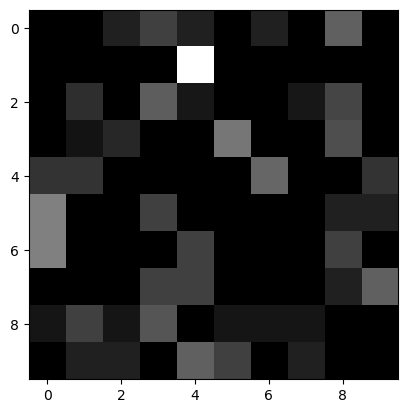

Epoch 1/20, error 0.1635294117647059
Epoch 2/20, error 0.0957983193277311
Epoch 3/20, error 0.09243697478991597
Epoch 4/20, error 0.07966386554621849
Epoch 5/20, error 0.07478991596638655
Epoch 6/20, error 0.07142857142857142
Epoch 7/20, error 0.06974789915966387
Epoch 8/20, error 0.06638655462184874
Epoch 9/20, error 0.06571428571428571
Epoch 10/20, error 0.06050420168067227
Epoch 11/20, error 0.06184873949579832
Epoch 12/20, error 0.05966386554621849
Epoch 13/20, error 0.055630252100840334
Epoch 1/20, error 0.15630252100840336
Epoch 2/20, error 0.09798319327731092
Epoch 3/20, error 0.08453781512605042
Epoch 4/20, error 0.07714285714285714
Epoch 5/20, error 0.07277310924369748
Epoch 6/20, error 0.07126050420168067
Epoch 7/20, error 0.06756302521008403
Epoch 8/20, error 0.06168067226890756
Epoch 9/20, error 0.06050420168067227
Epoch 10/20, error 0.05798319327731093
Epoch 11/20, error 0.06218487394957983
Epoch 12/20, error 0.05512605042016807
Epoch 13/20, error 0.05058823529411765
Epoch

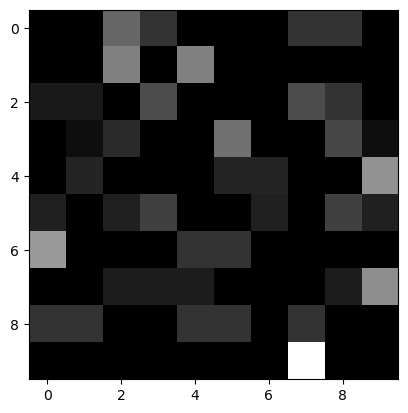

Epoch 1/20, error 0.16016806722689075
Epoch 2/20, error 0.1
Epoch 3/20, error 0.08319327731092437
Epoch 4/20, error 0.07529411764705882
Epoch 5/20, error 0.0692436974789916
Epoch 6/20, error 0.06941176470588235
Epoch 7/20, error 0.06285714285714286
Epoch 8/20, error 0.0611764705882353
Epoch 9/20, error 0.059327731092436976
Epoch 10/20, error 0.0519327731092437
Epoch 11/20, error 0.05680672268907563
Epoch 12/20, error 0.05310924369747899
Epoch 13/20, error 0.04907563025210084
Epoch 1/20, error 0.16134453781512606
Epoch 2/20, error 0.10285714285714286
Epoch 3/20, error 0.08890756302521008
Epoch 4/20, error 0.08285714285714285
Epoch 5/20, error 0.07899159663865546
Epoch 6/20, error 0.07344537815126051
Epoch 7/20, error 0.0653781512605042
Epoch 8/20, error 0.06823529411764706
Epoch 9/20, error 0.06336134453781513
Epoch 10/20, error 0.0653781512605042
Epoch 11/20, error 0.058823529411764705
Epoch 12/20, error 0.0611764705882353
Epoch 13/20, error 0.05848739495798319
Epoch 1/20, error 0.1630

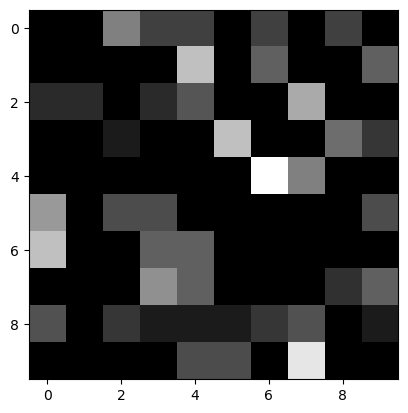

Epoch 1/20, error 0.1623529411764706
Epoch 2/20, error 0.10369747899159663
Epoch 3/20, error 0.08907563025210084
Epoch 4/20, error 0.08100840336134454
Epoch 5/20, error 0.07327731092436975
Epoch 6/20, error 0.07394957983193277
Epoch 7/20, error 0.06739495798319328
Epoch 8/20, error 0.066890756302521
Epoch 9/20, error 0.06235294117647059
Epoch 10/20, error 0.0611764705882353
Epoch 11/20, error 0.06050420168067227
Epoch 12/20, error 0.05260504201680672
Epoch 13/20, error 0.055630252100840334
Epoch 1/20, error 0.15865546218487395
Epoch 2/20, error 0.09915966386554621
Epoch 3/20, error 0.08521008403361345
Epoch 4/20, error 0.08151260504201681
Epoch 5/20, error 0.07680672268907562
Epoch 6/20, error 0.07563025210084033
Epoch 7/20, error 0.06840336134453781
Epoch 8/20, error 0.06369747899159664
Epoch 9/20, error 0.06504201680672268
Epoch 10/20, error 0.06050420168067227
Epoch 11/20, error 0.06218487394957983
Epoch 12/20, error 0.056134453781512605
Epoch 13/20, error 0.05647058823529412
Epoch 

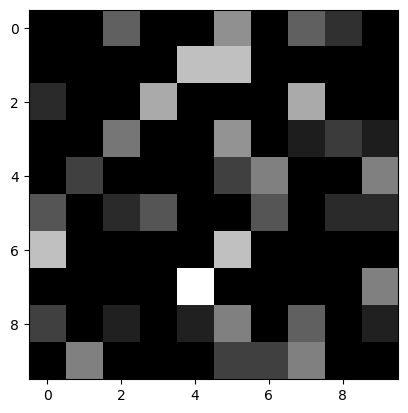

Epoch 1/20, error 0.15714285714285714
Epoch 2/20, error 0.09899159663865546
Epoch 3/20, error 0.08689075630252101
Epoch 4/20, error 0.07798319327731093
Epoch 5/20, error 0.06907563025210084
Epoch 6/20, error 0.06823529411764706
Epoch 7/20, error 0.0611764705882353
Epoch 8/20, error 0.0626890756302521
Epoch 9/20, error 0.05378151260504202
Epoch 10/20, error 0.05865546218487395
Epoch 11/20, error 0.056134453781512605
Epoch 12/20, error 0.049747899159663864
Epoch 13/20, error 0.05260504201680672
Epoch 1/20, error 0.15949579831932773
Epoch 2/20, error 0.10050420168067227
Epoch 3/20, error 0.0934453781512605
Epoch 4/20, error 0.08352941176470588
Epoch 5/20, error 0.0826890756302521
Epoch 6/20, error 0.07176470588235294
Epoch 7/20, error 0.07378151260504201
Epoch 8/20, error 0.06890756302521009
Epoch 9/20, error 0.06873949579831932
Epoch 10/20, error 0.06605042016806723
Epoch 11/20, error 0.06252100840336135
Epoch 12/20, error 0.05865546218487395
Epoch 13/20, error 0.05798319327731093
Epoch 

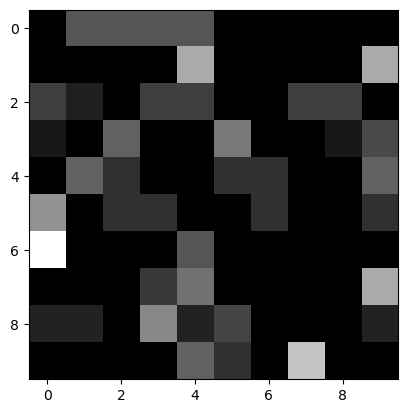

Epoch 1/20, error 0.1588235294117647
Epoch 2/20, error 0.09831932773109243
Epoch 3/20, error 0.08672268907563026
Epoch 4/20, error 0.07865546218487394
Epoch 5/20, error 0.07394957983193277
Epoch 6/20, error 0.06941176470588235
Epoch 7/20, error 0.06369747899159664
Epoch 8/20, error 0.06504201680672268
Epoch 9/20, error 0.06302521008403361
Epoch 10/20, error 0.05546218487394958
Epoch 11/20, error 0.05647058823529412
Epoch 12/20, error 0.05378151260504202
Epoch 13/20, error 0.05226890756302521
Epoch 1/20, error 0.16016806722689075
Epoch 2/20, error 0.1011764705882353
Epoch 3/20, error 0.08823529411764706
Epoch 4/20, error 0.07546218487394958
Epoch 5/20, error 0.07512605042016807
Epoch 6/20, error 0.07176470588235294
Epoch 7/20, error 0.06823529411764706
Epoch 8/20, error 0.066890756302521
Epoch 9/20, error 0.06319327731092438
Epoch 10/20, error 0.05983193277310924
Epoch 11/20, error 0.058151260504201684
Epoch 12/20, error 0.0546218487394958
Epoch 13/20, error 0.05630252100840336
Epoch 1/

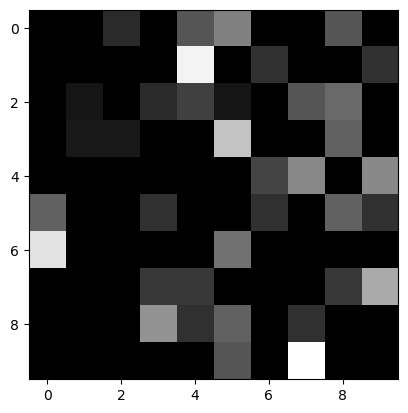

Epoch 1/20, error 0.15899159663865547
Epoch 2/20, error 0.10252100840336134
Epoch 3/20, error 0.08605042016806723
Epoch 4/20, error 0.08453781512605042
Epoch 5/20, error 0.0773109243697479
Epoch 6/20, error 0.0757983193277311
Epoch 7/20, error 0.07176470588235294
Epoch 8/20, error 0.0719327731092437
Epoch 9/20, error 0.06588235294117648
Epoch 10/20, error 0.062016806722689076
Epoch 11/20, error 0.0611764705882353
Epoch 12/20, error 0.0573109243697479
Epoch 13/20, error 0.05915966386554622
Epoch 1/20, error 0.15932773109243697
Epoch 2/20, error 0.09915966386554621
Epoch 3/20, error 0.08957983193277311
Epoch 4/20, error 0.08218487394957984
Epoch 5/20, error 0.07663865546218487
Epoch 6/20, error 0.07058823529411765
Epoch 7/20, error 0.0653781512605042
Epoch 8/20, error 0.06621848739495799
Epoch 9/20, error 0.056134453781512605
Epoch 10/20, error 0.06084033613445378
Epoch 11/20, error 0.05663865546218488
Epoch 12/20, error 0.058319327731092434
Epoch 13/20, error 0.05663865546218488
Epoch 1

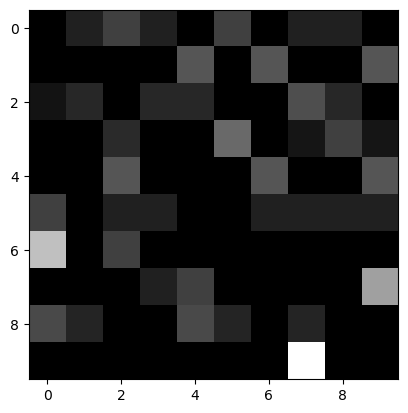

Epoch 1/20, error 0.15445378151260505
Epoch 2/20, error 0.09260504201680672
Epoch 3/20, error 0.07815126050420168
Epoch 4/20, error 0.07546218487394958
Epoch 5/20, error 0.07176470588235294
Epoch 6/20, error 0.06907563025210084
Epoch 7/20, error 0.06705882352941177
Epoch 8/20, error 0.060168067226890755
Epoch 9/20, error 0.058151260504201684
Epoch 10/20, error 0.0546218487394958
Epoch 11/20, error 0.05983193277310924
Epoch 12/20, error 0.05663865546218488
Epoch 13/20, error 0.052941176470588235
Epoch 1/20, error 0.1573109243697479
Epoch 2/20, error 0.10067226890756302
Epoch 3/20, error 0.09008403361344537
Epoch 4/20, error 0.08571428571428572
Epoch 5/20, error 0.07747899159663865
Epoch 6/20, error 0.07109243697478991
Epoch 7/20, error 0.06789915966386555
Epoch 8/20, error 0.06672268907563025
Epoch 9/20, error 0.06722689075630252
Epoch 10/20, error 0.06235294117647059
Epoch 11/20, error 0.05915966386554622
Epoch 12/20, error 0.05949579831932773
Epoch 13/20, error 0.05848739495798319
Epo

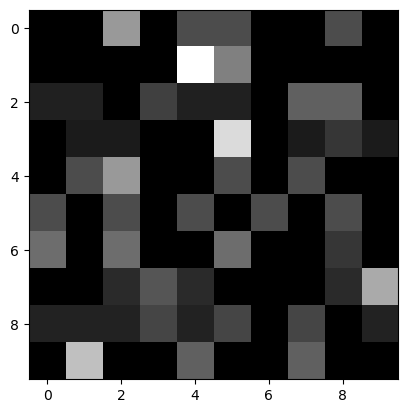

Epoch 1/20, error 0.15865546218487395
Epoch 2/20, error 0.09663865546218488
Epoch 3/20, error 0.09394957983193278
Epoch 4/20, error 0.08235294117647059
Epoch 5/20, error 0.0757983193277311
Epoch 6/20, error 0.0692436974789916
Epoch 7/20, error 0.06504201680672268
Epoch 8/20, error 0.06554621848739496
Epoch 9/20, error 0.06941176470588235
Epoch 10/20, error 0.05966386554621849
Epoch 11/20, error 0.06285714285714286
Epoch 12/20, error 0.05411764705882353
Epoch 13/20, error 0.055630252100840334
Epoch 1/20, error 0.15210084033613444
Epoch 2/20, error 0.1011764705882353
Epoch 3/20, error 0.08941176470588236
Epoch 4/20, error 0.08184873949579832
Epoch 5/20, error 0.07815126050420168
Epoch 6/20, error 0.07159663865546219
Epoch 7/20, error 0.0692436974789916
Epoch 8/20, error 0.06386554621848739
Epoch 9/20, error 0.06100840336134454
Epoch 10/20, error 0.06302521008403361
Epoch 11/20, error 0.059327731092436976
Epoch 12/20, error 0.056974789915966384
Epoch 13/20, error 0.06033613445378151
Epoch

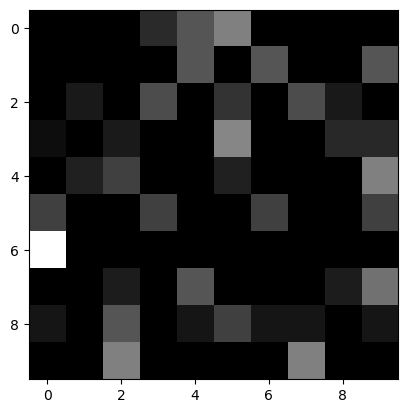

Epoch 1/20, error 0.15747899159663867
Epoch 2/20, error 0.09865546218487395
Epoch 3/20, error 0.0880672268907563
Epoch 4/20, error 0.08319327731092437
Epoch 5/20, error 0.07495798319327732
Epoch 6/20, error 0.0719327731092437
Epoch 7/20, error 0.07058823529411765
Epoch 8/20, error 0.0653781512605042
Epoch 9/20, error 0.060672268907563026
Epoch 10/20, error 0.06218487394957983
Epoch 11/20, error 0.06319327731092438
Epoch 12/20, error 0.05714285714285714
Epoch 13/20, error 0.057478991596638655
Epoch 1/20, error 0.1618487394957983
Epoch 2/20, error 0.09663865546218488
Epoch 3/20, error 0.09462184873949579
Epoch 4/20, error 0.08453781512605042
Epoch 5/20, error 0.07294117647058823
Epoch 6/20, error 0.0757983193277311
Epoch 7/20, error 0.07025210084033613
Epoch 8/20, error 0.06789915966386555
Epoch 9/20, error 0.06605042016806723
Epoch 10/20, error 0.06235294117647059
Epoch 11/20, error 0.06235294117647059
Epoch 12/20, error 0.05680672268907563
Epoch 13/20, error 0.05865546218487395
Epoch 1

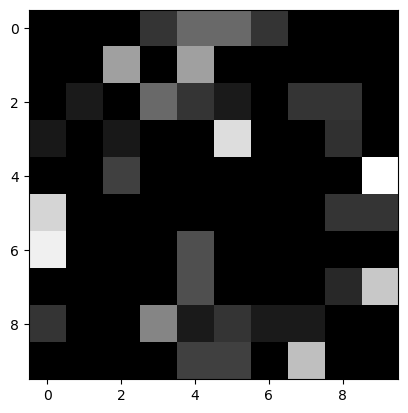

Epoch 1/20, error 0.16050420168067228
Epoch 2/20, error 0.09831932773109243
Epoch 3/20, error 0.08436974789915966
Epoch 4/20, error 0.07865546218487394
Epoch 5/20, error 0.07596638655462185
Epoch 6/20, error 0.06722689075630252
Epoch 7/20, error 0.06504201680672268
Epoch 8/20, error 0.06235294117647059
Epoch 9/20, error 0.05579831932773109
Epoch 10/20, error 0.05663865546218488
Epoch 11/20, error 0.05949579831932773
Epoch 12/20, error 0.054789915966386556
Epoch 13/20, error 0.05680672268907563
Epoch 1/20, error 0.16285714285714287
Epoch 2/20, error 0.10420168067226891
Epoch 3/20, error 0.09294117647058824
Epoch 4/20, error 0.08907563025210084
Epoch 5/20, error 0.0811764705882353
Epoch 6/20, error 0.07815126050420168
Epoch 7/20, error 0.07411764705882352
Epoch 8/20, error 0.07025210084033613
Epoch 9/20, error 0.06521008403361345
Epoch 10/20, error 0.07142857142857142
Epoch 11/20, error 0.06823529411764706
Epoch 12/20, error 0.06285714285714286
Epoch 13/20, error 0.06235294117647059
Epoc

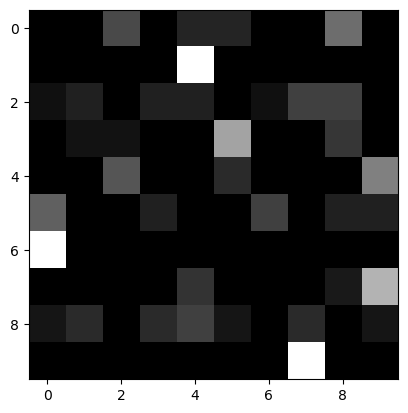

Epoch 1/20, error 0.15949579831932773
Epoch 2/20, error 0.10016806722689076
Epoch 3/20, error 0.08521008403361345
Epoch 4/20, error 0.07831932773109243
Epoch 5/20, error 0.07277310924369748
Epoch 6/20, error 0.07008403361344538
Epoch 7/20, error 0.06504201680672268
Epoch 8/20, error 0.06588235294117648
Epoch 9/20, error 0.0611764705882353
Epoch 10/20, error 0.05798319327731093
Epoch 11/20, error 0.05495798319327731
Epoch 12/20, error 0.05327731092436975
Epoch 13/20, error 0.04991596638655462
Epoch 1/20, error 0.15915966386554622
Epoch 2/20, error 0.09546218487394958
Epoch 3/20, error 0.08605042016806723
Epoch 4/20, error 0.07596638655462185
Epoch 5/20, error 0.07865546218487394
Epoch 6/20, error 0.07058823529411765
Epoch 7/20, error 0.06504201680672268
Epoch 8/20, error 0.06134453781512605
Epoch 9/20, error 0.06369747899159664
Epoch 10/20, error 0.057478991596638655
Epoch 11/20, error 0.05579831932773109
Epoch 12/20, error 0.05647058823529412
Epoch 13/20, error 0.05058823529411765
Epoc

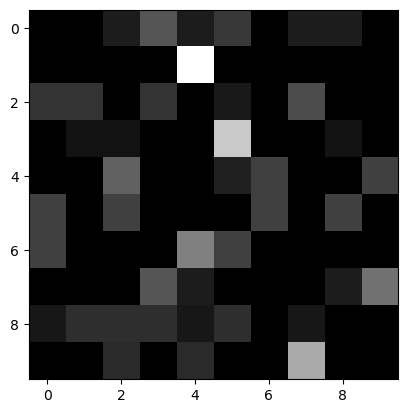

Epoch 1/20, error 0.15361344537815125
Epoch 2/20, error 0.09411764705882353
Epoch 3/20, error 0.08705882352941176
Epoch 4/20, error 0.07445378151260504
Epoch 5/20, error 0.06991596638655462
Epoch 6/20, error 0.06621848739495799
Epoch 7/20, error 0.06857142857142857
Epoch 8/20, error 0.06336134453781513
Epoch 9/20, error 0.058151260504201684
Epoch 10/20, error 0.059327731092436976
Epoch 11/20, error 0.04991596638655462
Epoch 12/20, error 0.05142857142857143
Epoch 13/20, error 0.047058823529411764
Epoch 1/20, error 0.15815126050420167
Epoch 2/20, error 0.10218487394957983
Epoch 3/20, error 0.09310924369747899
Epoch 4/20, error 0.08521008403361345
Epoch 5/20, error 0.07546218487394958
Epoch 6/20, error 0.07176470588235294
Epoch 7/20, error 0.06588235294117648
Epoch 8/20, error 0.06722689075630252
Epoch 9/20, error 0.0653781512605042
Epoch 10/20, error 0.0626890756302521
Epoch 11/20, error 0.05798319327731093
Epoch 12/20, error 0.0626890756302521
Epoch 13/20, error 0.0573109243697479
Epoch

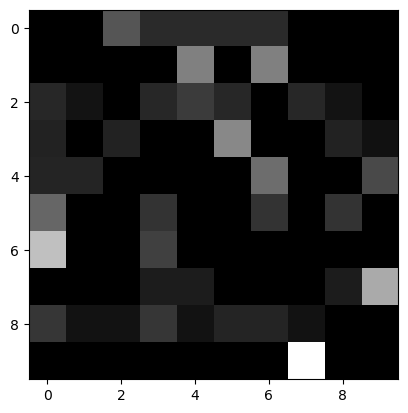

Epoch 1/20, error 0.15966386554621848
Epoch 2/20, error 0.10436974789915966
Epoch 3/20, error 0.09378151260504201
Epoch 4/20, error 0.08352941176470588
Epoch 5/20, error 0.07680672268907562
Epoch 6/20, error 0.07647058823529412
Epoch 7/20, error 0.07092436974789916
Epoch 8/20, error 0.06823529411764706
Epoch 9/20, error 0.06789915966386555
Epoch 10/20, error 0.06873949579831932
Epoch 11/20, error 0.06285714285714286
Epoch 12/20, error 0.06084033613445378
Epoch 13/20, error 0.05966386554621849
Epoch 1/20, error 0.15663865546218486
Epoch 2/20, error 0.1026890756302521
Epoch 3/20, error 0.08689075630252101
Epoch 4/20, error 0.08168067226890756
Epoch 5/20, error 0.08100840336134454
Epoch 6/20, error 0.07210084033613445
Epoch 7/20, error 0.07210084033613445
Epoch 8/20, error 0.06588235294117648
Epoch 9/20, error 0.0611764705882353
Epoch 10/20, error 0.0626890756302521
Epoch 11/20, error 0.05848739495798319
Epoch 12/20, error 0.060672268907563026
Epoch 13/20, error 0.055630252100840334
Epoch

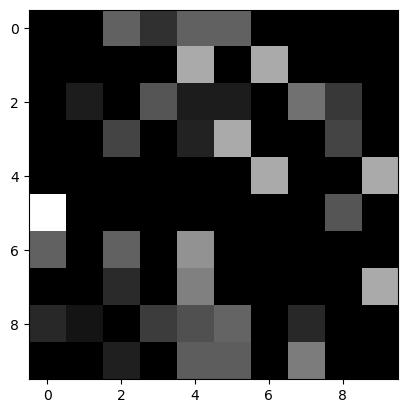

Epoch 1/20, error 0.15831932773109245
Epoch 2/20, error 0.09899159663865546
Epoch 3/20, error 0.08957983193277311
Epoch 4/20, error 0.08336134453781513
Epoch 5/20, error 0.0757983193277311
Epoch 6/20, error 0.07008403361344538
Epoch 7/20, error 0.07025210084033613
Epoch 8/20, error 0.07226890756302522
Epoch 9/20, error 0.06218487394957983
Epoch 10/20, error 0.058319327731092434
Epoch 11/20, error 0.059327731092436976
Epoch 12/20, error 0.05226890756302521
Epoch 13/20, error 0.05848739495798319
Epoch 1/20, error 0.15714285714285714
Epoch 2/20, error 0.09428571428571429
Epoch 3/20, error 0.08453781512605042
Epoch 4/20, error 0.08218487394957984
Epoch 5/20, error 0.06739495798319328
Epoch 6/20, error 0.06504201680672268
Epoch 7/20, error 0.06386554621848739
Epoch 8/20, error 0.06504201680672268
Epoch 9/20, error 0.0573109243697479
Epoch 10/20, error 0.05714285714285714
Epoch 11/20, error 0.0519327731092437
Epoch 12/20, error 0.0546218487394958
Epoch 13/20, error 0.04941176470588235
Epoch 

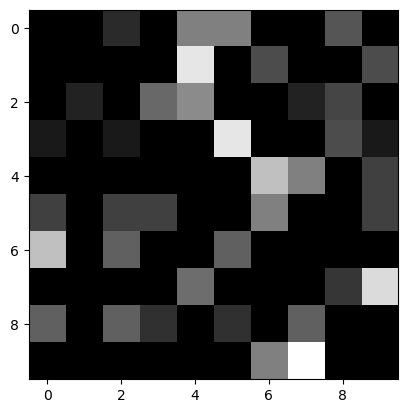

Epoch 1/20, error 0.16470588235294117
Epoch 2/20, error 0.10403361344537815
Epoch 3/20, error 0.09109243697478991
Epoch 4/20, error 0.08067226890756303
Epoch 5/20, error 0.07529411764705882
Epoch 6/20, error 0.07226890756302522
Epoch 7/20, error 0.07159663865546219
Epoch 8/20, error 0.06504201680672268
Epoch 9/20, error 0.06672268907563025
Epoch 10/20, error 0.06134453781512605
Epoch 11/20, error 0.06235294117647059
Epoch 12/20, error 0.05529411764705883
Epoch 13/20, error 0.05983193277310924
Epoch 1/20, error 0.15932773109243697
Epoch 2/20, error 0.10420168067226891
Epoch 3/20, error 0.0907563025210084
Epoch 4/20, error 0.08084033613445378
Epoch 5/20, error 0.07882352941176471
Epoch 6/20, error 0.0719327731092437
Epoch 7/20, error 0.07142857142857142
Epoch 8/20, error 0.06873949579831932
Epoch 9/20, error 0.06588235294117648
Epoch 10/20, error 0.06638655462184874
Epoch 11/20, error 0.06336134453781513
Epoch 12/20, error 0.05983193277310924
Epoch 13/20, error 0.05512605042016807
Epoch 

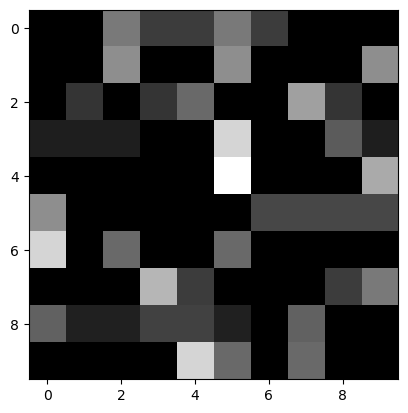

Epoch 1/20, error 0.15563025210084033
Epoch 2/20, error 0.09983193277310924
Epoch 3/20, error 0.09042016806722689
Epoch 4/20, error 0.0838655462184874
Epoch 5/20, error 0.07882352941176471
Epoch 6/20, error 0.07495798319327732
Epoch 7/20, error 0.06621848739495799
Epoch 8/20, error 0.0642016806722689
Epoch 9/20, error 0.0611764705882353
Epoch 10/20, error 0.06504201680672268
Epoch 11/20, error 0.062016806722689076
Epoch 12/20, error 0.05680672268907563
Epoch 13/20, error 0.06084033613445378
Epoch 1/20, error 0.15663865546218486
Epoch 2/20, error 0.10235294117647059
Epoch 3/20, error 0.08521008403361345
Epoch 4/20, error 0.07714285714285714
Epoch 5/20, error 0.07831932773109243
Epoch 6/20, error 0.06890756302521009
Epoch 7/20, error 0.06941176470588235
Epoch 8/20, error 0.061512605042016805
Epoch 9/20, error 0.062016806722689076
Epoch 10/20, error 0.058823529411764705
Epoch 11/20, error 0.05596638655462185
Epoch 12/20, error 0.05495798319327731
Epoch 13/20, error 0.05512605042016807
Epo

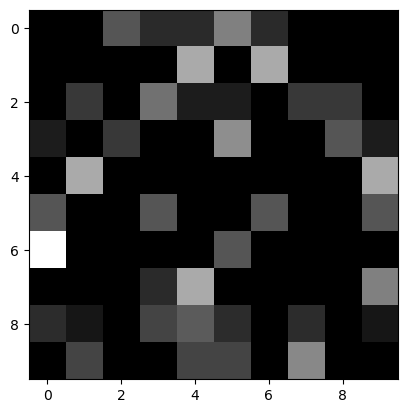

Epoch 1/20, error 0.16067226890756303
Epoch 2/20, error 0.10453781512605043
Epoch 3/20, error 0.08487394957983194
Epoch 4/20, error 0.0826890756302521
Epoch 5/20, error 0.07815126050420168
Epoch 6/20, error 0.07176470588235294
Epoch 7/20, error 0.06554621848739496
Epoch 8/20, error 0.06605042016806723
Epoch 9/20, error 0.06184873949579832
Epoch 10/20, error 0.06050420168067227
Epoch 11/20, error 0.054789915966386556
Epoch 12/20, error 0.05445378151260504
Epoch 13/20, error 0.05243697478991596
Epoch 1/20, error 0.15294117647058825
Epoch 2/20, error 0.0976470588235294
Epoch 3/20, error 0.0826890756302521
Epoch 4/20, error 0.07966386554621849
Epoch 5/20, error 0.07714285714285714
Epoch 6/20, error 0.06655462184873949
Epoch 7/20, error 0.06941176470588235
Epoch 8/20, error 0.06436974789915967
Epoch 9/20, error 0.05983193277310924
Epoch 10/20, error 0.06100840336134454
Epoch 11/20, error 0.05714285714285714
Epoch 12/20, error 0.058823529411764705
Epoch 13/20, error 0.05058823529411765
Epoch

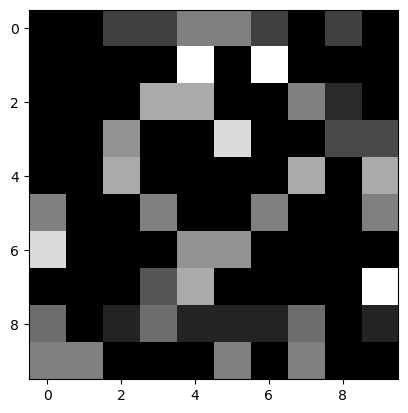

Epoch 1/20, error 0.1623529411764706
Epoch 2/20, error 0.10084033613445378
Epoch 3/20, error 0.09159663865546218
Epoch 4/20, error 0.08352941176470588
Epoch 5/20, error 0.07596638655462185
Epoch 6/20, error 0.073109243697479
Epoch 7/20, error 0.06907563025210084
Epoch 8/20, error 0.0680672268907563
Epoch 9/20, error 0.06605042016806723
Epoch 10/20, error 0.060168067226890755
Epoch 11/20, error 0.05848739495798319
Epoch 12/20, error 0.06168067226890756
Epoch 13/20, error 0.054285714285714284
Epoch 1/20, error 0.1561344537815126
Epoch 2/20, error 0.09831932773109243
Epoch 3/20, error 0.08890756302521008
Epoch 4/20, error 0.07882352941176471
Epoch 5/20, error 0.07159663865546219
Epoch 6/20, error 0.06941176470588235
Epoch 7/20, error 0.06605042016806723
Epoch 8/20, error 0.06571428571428571
Epoch 9/20, error 0.06907563025210084
Epoch 10/20, error 0.058823529411764705
Epoch 11/20, error 0.05579831932773109
Epoch 12/20, error 0.056974789915966384
Epoch 13/20, error 0.051092436974789913
Epoc

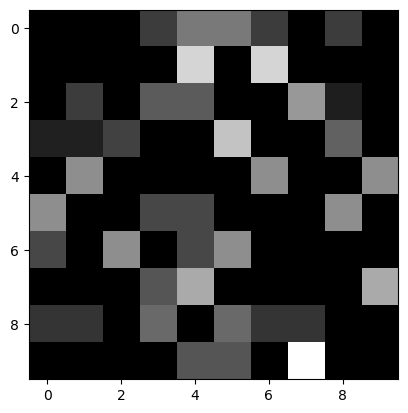

Epoch 1/20, error 0.16117647058823528
Epoch 2/20, error 0.10504201680672269
Epoch 3/20, error 0.08907563025210084
Epoch 4/20, error 0.08235294117647059
Epoch 5/20, error 0.07411764705882352
Epoch 6/20, error 0.07126050420168067
Epoch 7/20, error 0.07159663865546219
Epoch 8/20, error 0.06907563025210084
Epoch 9/20, error 0.06672268907563025
Epoch 10/20, error 0.060672268907563026
Epoch 11/20, error 0.06571428571428571
Epoch 12/20, error 0.060672268907563026
Epoch 13/20, error 0.06352941176470588
Epoch 1/20, error 0.15899159663865547
Epoch 2/20, error 0.10050420168067227
Epoch 3/20, error 0.08756302521008404
Epoch 4/20, error 0.08235294117647059
Epoch 5/20, error 0.07596638655462185
Epoch 6/20, error 0.07647058823529412
Epoch 7/20, error 0.06655462184873949
Epoch 8/20, error 0.06504201680672268
Epoch 9/20, error 0.06033613445378151
Epoch 10/20, error 0.062016806722689076
Epoch 11/20, error 0.0573109243697479
Epoch 12/20, error 0.06050420168067227
Epoch 13/20, error 0.05579831932773109
Ep

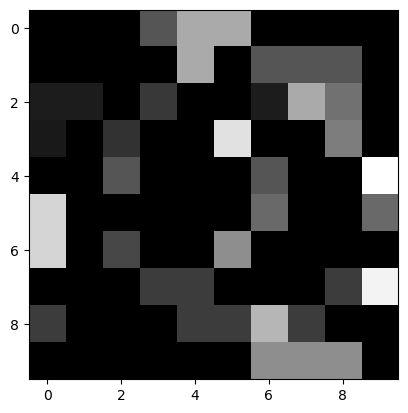

In [61]:
n_folds = 5
n_runs = 20
degrees = range(1, 8)
best_degrees = []
train_errors = []
test_errors = []
confusion_matrices = []

for _ in range(n_runs):
    # Step (i): Train-test split
    train, test = train_test_split(data, split_label = False)

    # Step (ii): Cross-validation to find the best degree
    sets = n_fold_split(train, n_folds)

    # track the errors
    mean_fold_errors = []
    for d in degrees:
        degree = d
        fold_errors = []
        for num in range(n_folds):
            train, validate = sets[num]
            X_train = train[:, 1:]
            y_train = train[:, 0]
            X_validate = validate[:, 1:]
            y_validate = validate[:, 0]
            # Train the model
            model = OneVsRestPerceptron(X_train, y_train, kernel=polynomial_kernel, degree=degree)
            weights, mean_error = model.train(optimal_epochs=13)

            # Evaluate on validation set
            error = model.test(X_validate, y_validate)
            fold_errors.append(error)
        mean_fold_errors.append(np.mean(fold_errors))

    best_degree = np.argmin(mean_fold_errors) + 1
    best_degrees.append(best_degree)

    # Step (iii): Retrain with the best degree
    X_train = train[:, 1:]
    y_train = train[:, 0]
    X_test = test[:, 1:]
    y_test = test[:, 0]

    model = OneVsRestPerceptron(X_train, y_train, kernel=polynomial_kernel, degree=best_degree)
    weights, mean_error = model.train(optimal_epochs=13)
    train_errors.append(mean_error)

    # Evaluate on test set
    error = model.test(X_test, y_test)
    test_errors.append(error)
    confusion_matrix = model.confusion_matrix(X_test, y_test)
    confusion_matrices.append(confusion_matrix)




Degree	Train Error	Test Error
4	0.1008	4.1935
5	0.1848	3.9785
5	0.1680	4.1398
6	0.0336	3.8710
5	0.0000	3.8710
5	0.1176	4.1398
5	0.0000	3.8172
4	0.1008	4.0323
3	0.3193	4.0323
5	0.0672	3.9247
6	0.0504	4.1398
7	0.0672	4.1935
4	0.0336	4.1398
5	0.1512	4.3011
3	0.0840	3.9785
5	0.1176	3.8172
4	0.0504	3.8710
4	0.1008	3.6022
7	0.0000	3.7097
3	0.1008	3.9785
[[0.         0.01875    0.19605159 0.13517857 0.19507937 0.23902778
  0.05803571 0.03430556 0.12357143 0.        ]
 [0.         0.         0.06666667 0.         0.55238095 0.05833333
  0.19797619 0.01       0.01       0.10464286]
 [0.05736548 0.10221036 0.         0.23103577 0.13849935 0.04248397
  0.00645833 0.27064366 0.15130307 0.        ]
 [0.03457459 0.02832723 0.1407609  0.         0.005      0.51619908
  0.         0.01158425 0.20189244 0.06166153]
 [0.01714286 0.10482143 0.12839286 0.         0.         0.08345238
  0.22154762 0.08       0.         0.36464286]
 [0.3468254  0.         0.06603175 0.13706349 0.01833333 0.
  0.15789683 0.

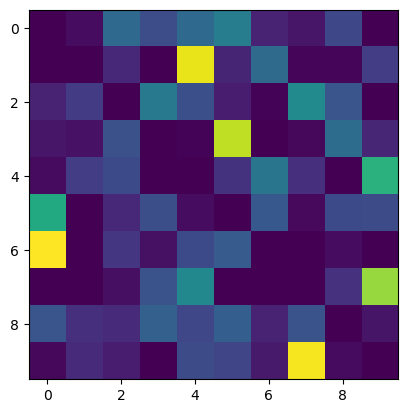

In [69]:
# show the results in a table, show degree train error and test error
train_errors_percent = np.array(train_errors) * 100
test_errors_percent = np.array(test_errors) * 100
print('Degree\tTrain Error\tTest Error')
for i in range(n_runs):
    print(f'{best_degrees[i]}\t{train_errors_percent[i]:.4f}\t{test_errors_percent[i]:.4f}')
    
# show the confusion matrix
confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.imshow(confusion_matrix)
print(confusion_matrix)

# average degree
print(np.mean(best_degrees))

# overall test error, train error, degree, with standard deviation
print(f'Test error: {np.mean(test_errors_percent):.4f} ± {np.std(test_errors_percent):.4f}')
print(f'Train error: {np.mean(train_errors_percent):.4f} ± {np.std(train_errors_percent):.4f}')
print(f'Degree: {np.mean(best_degrees)} ± {np.std(best_degrees):.4f}')

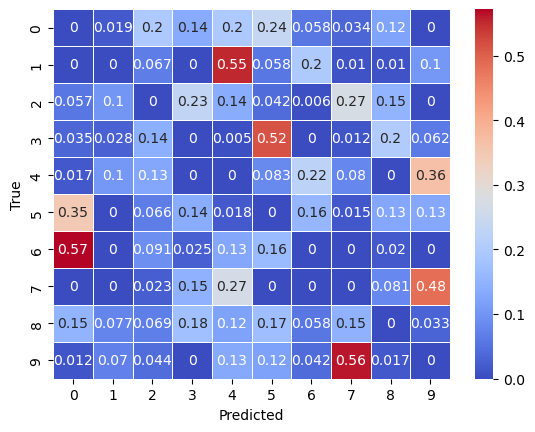

In [75]:

import seaborn as sns
sns.heatmap(confusion_matrix.round(3), annot=True, linewidth=.5, cmap='coolwarm')
plt.savefig('confusion_matrix.png')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

In [60]:
# Q6 Hard-to-predict digits
# we run it for N times and take the more frequent hard-to-predict digits
# In each run, we find the hard-to-predict digits and store them
Feature = data[:, 1:]
Label = data[:, 0].astype(int)
hard_to_predict = np.zeros_like(0.2*Label)
for run in range(50):
    X_train, Y_train, X_test, Y_test = train_test_split(data)
    model = OneVsRestPerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=5)
    weights, mean_error = model.train(optimal_epochs=15)

    # predict the test set
    predictions = model.predict(Feature)

    hard_to_predict[np.argwhere(predictions != Label)] += 1

print(np.argsort(hard_to_predict)[-5:])



Epoch 1/20, error 0.08012906695348213
Epoch 2/20, error 0.016536703414896478
Epoch 3/20, error 0.00578112395805324
Epoch 4/20, error 0.004571121269158376
Epoch 5/20, error 0.004705566012368916
Epoch 6/20, error 0.0029577843506318905
Epoch 7/20, error 0.00282333960742135
Epoch 8/20, error 0.002285560634579188
Epoch 9/20, error 0.0013444474321054048
Epoch 10/20, error 0.0008066684592632429
Epoch 11/20, error 0.0009411132024737832
Epoch 12/20, error 0.0009411132024737832
Epoch 13/20, error 0.0005377789728421619
Epoch 14/20, error 0.0009411132024737832
Epoch 15/20, error 0.0006722237160527024
Epoch 1/20, error 0.07865017477816617
Epoch 2/20, error 0.019225598279107286
Epoch 3/20, error 0.008201129335842968
Epoch 4/20, error 0.005243344985211078
Epoch 5/20, error 0.0032266738370529714
Epoch 6/20, error 0.002285560634579188
Epoch 7/20, error 0.0017477816617370262
Epoch 8/20, error 0.0008066684592632429
Epoch 9/20, error 0.0010755579456843238
Epoch 10/20, error 0.0009411132024737832
Epoch 11/

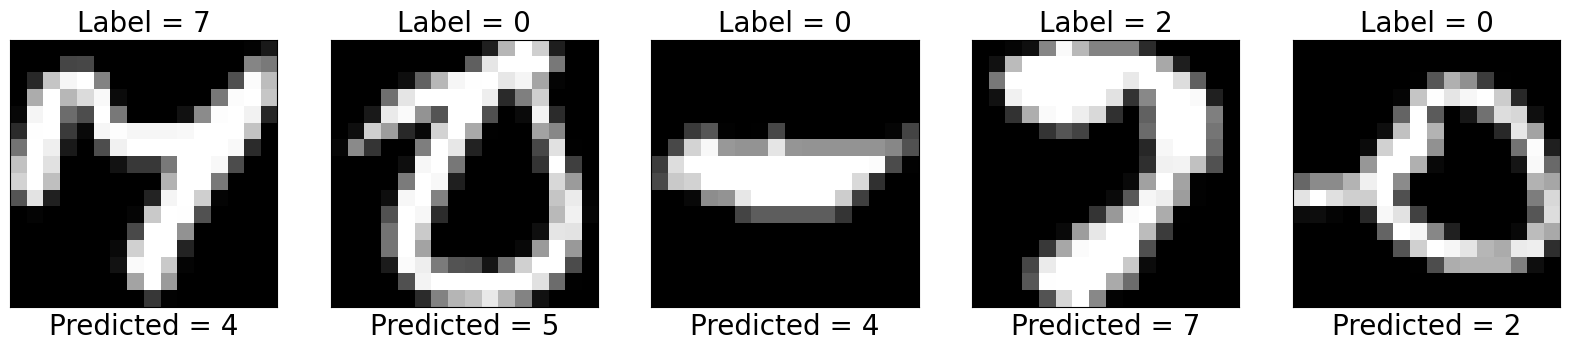

In [65]:
# Visualizing the most misclassified images
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
for index, image_index in enumerate(np.argsort(hard_to_predict)[-5:]):
    ax = axes[index]
    ax.imshow(Feature[image_index, :].reshape(16, 16), cmap="gray")
    ax.set_title(f'Label = {int(Label[image_index])}', fontsize=20)
    ax.set_xlabel(f'Predicted = {int(predictions[image_index])}', fontsize=20)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

plt.savefig('hard_to_predict.png', bbox_inches='tight')
plt.show()


Epoch 1/20, error 0.08026351169669266
Epoch 2/20, error 0.01720892713094918
Epoch 3/20, error 0.006184458187684862
Epoch 4/20, error 0.004302231782737295
Epoch 5/20, error 0.002554450121000269
Epoch 6/20, error 0.002016671148158107
Epoch 7/20, error 0.002016671148158107
Epoch 8/20, error 0.0014788921753159452
Epoch 9/20, error 0.002016671148158107
Epoch 10/20, error 0.002016671148158107
Epoch 11/20, error 0.0006722237160527024
Epoch 12/20, error 0.00040333422963162143
Epoch 13/20, error 0.0009411132024737832
Epoch 14/20, error 0.0005377789728421619
Epoch 15/20, error 0.0008066684592632429
Epoch 1/20, error 0.08053240118311374
Epoch 2/20, error 0.016267813928475396
Epoch 3/20, error 0.006856681903737564
Epoch 4/20, error 0.006587792417316483
Epoch 5/20, error 0.004302231782737295
Epoch 6/20, error 0.0024200053777897286
Epoch 7/20, error 0.0006722237160527024
Epoch 8/20, error 0.0018822264049475664
Epoch 9/20, error 0.0009411132024737832
Epoch 10/20, error 0.0008066684592632429
Epoch 11/

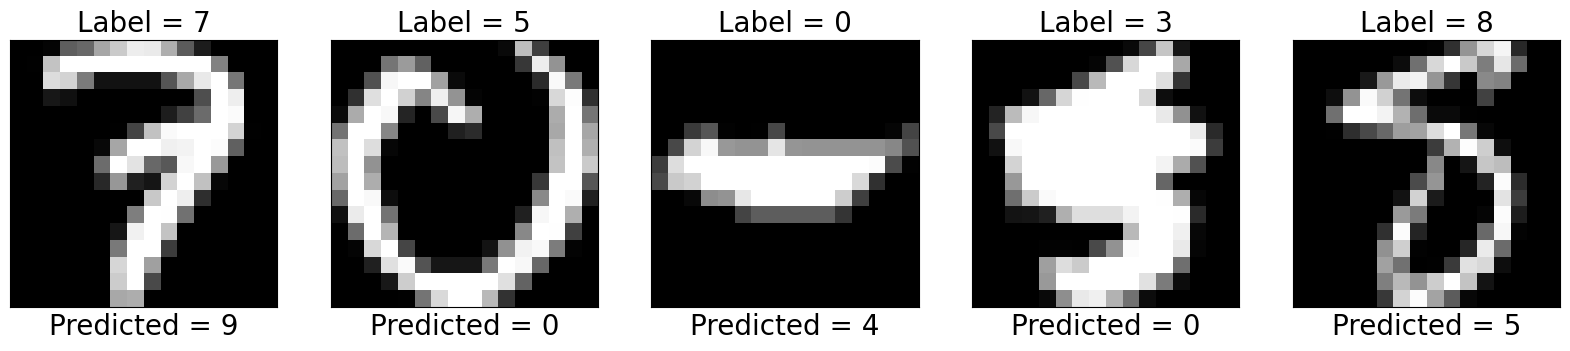

In [76]:
Feature = data[:, 1:]
Label = data[:, 0].astype(int)
hard_to_predict = np.zeros_like(0.2*Label)
for run in range(50):
    X_train, Y_train, X_test, Y_test = train_test_split(data)
    model = OneVsRestPerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=5)
    weights, mean_error = model.train(optimal_epochs=15)

    # predict the test set
    predictions = model.predict(X_test)

    hard_to_predict[np.argwhere(predictions != Y_test)] += 1

# Visualizing the most misclassified images
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
for index, image_index in enumerate(np.argsort(hard_to_predict)[-5:]):
    ax = axes[index]
    ax.imshow(X_test[image_index, :].reshape(16, 16), cmap="gray")
    ax.set_title(f'Label = {int(Y_test[image_index])}', fontsize=20)
    ax.set_xlabel(f'Predicted = {int(predictions[image_index])}', fontsize=20)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

plt.savefig('hard_to_predict.png', bbox_inches='tight')
plt.show()


In [109]:
# Q7 Gaussian Kernel
# find the optimal gamma
def find_optimal_c(gamma):
    train_errors = []
    test_errors = []
    for g in gamma:
        X_train, Y_train, X_test, Y_test = train_test_split(data)
        model = OneVsRestPerceptron(X_train, Y_train, degree=g, kernel=gaussian_kernel)
        weights, mean_error = model.train()
        error = model.test(X_test, Y_test)
        print(f'Gamma: {g}, Test error: {error}')
        train_errors.append(mean_error[-1])
        test_errors.append(error)
    # print the results

    print('Gamma\tTrain Error\tTest Error')
    for i in range(7):
          print(f'{gamma[i]:.4f}\t{train_errors[i]*100:.4f}\t{test_errors[i]*100:.4f}')

power = np.linspace(-10, 0, 7)
gamma_first = [2**i for i in power]
find_optimal_c(gamma_first)

Epoch 1/20, error 0.19292820650712558
Epoch 2/20, error 0.10957246571659048
Epoch 3/20, error 0.09088464641032536
Epoch 4/20, error 0.08241462758806131
Epoch 5/20, error 0.07448238773863942
Epoch 6/20, error 0.06574347942995429
Epoch 7/20, error 0.062113471363269696
Epoch 8/20, error 0.06036568970153267
Epoch 9/20, error 0.05135789190642646
Epoch 10/20, error 0.04692121538047862
Epoch 11/20, error 0.04571121269158376
Epoch 12/20, error 0.04530787846195214
Epoch 13/20, error 0.041812315138478086
Epoch 14/20, error 0.03831675181500403
Epoch 15/20, error 0.036300080666845924
Epoch 16/20, error 0.03401452003226674
Epoch 17/20, error 0.03576230169400377
Epoch 18/20, error 0.03374563054584566
Epoch 19/20, error 0.03253562785695079
Epoch 20/20, error 0.030250067222371606
Gamma: 0.0009765625, Test error: 0.07096774193548387
Epoch 1/20, error 0.12463027695617102
Epoch 2/20, error 0.062382360849690774
Epoch 3/20, error 0.03858564130142511
Epoch 4/20, error 0.02904006453347674
Epoch 5/20, error 0

In [113]:
for i in power:
    print(i)

second_power = np.linspace(-8.5, -5, 7)
gamma_second = [2**i for i in second_power]
find_optimal_c(gamma_second)

-10.0
-8.333333333333334
-6.666666666666666
-5.0
-3.333333333333333
-1.666666666666666
0.0
Epoch 1/20, error 0.13673030384511967
Epoch 2/20, error 0.06157569239042753
Epoch 3/20, error 0.04692121538047862
Epoch 4/20, error 0.04046786770637268
Epoch 5/20, error 0.024872277493949987
Epoch 6/20, error 0.022452272116160257
Epoch 7/20, error 0.021107824684054855
Epoch 8/20, error 0.019091153535896747
Epoch 9/20, error 0.015864479698843775
Epoch 10/20, error 0.013444474321054048
Epoch 11/20, error 0.008066684592632429
Epoch 12/20, error 0.010755579456843238
Epoch 13/20, error 0.007125571390158645
Epoch 14/20, error 0.006856681903737564
Epoch 15/20, error 0.007260016133369185
Epoch 16/20, error 0.009007797795106211
Epoch 17/20, error 0.005377789728421619
Epoch 18/20, error 0.005243344985211078
Epoch 19/20, error 0.005243344985211078
Epoch 1/20, error 0.006050013444474321
Epoch 2/20, error 0.006722237160527024
Epoch 3/20, error 0.0038988975531056734
Epoch 4/20, error 0.0036300080666845924
Epoc

In [115]:
for i in second_power:
    print(i)

final_power = np.linspace(-6.5, -5, 7)
gamma_final = [2**i for i in final_power]

-8.5
-7.916666666666667
-7.333333333333333
-6.75
-6.166666666666666
-5.583333333333333
-5.0


In [116]:
# Q7(b) Basic results
train_errors = []
test_errors = []
for degree in gamma_final:
    train_error = np.zeros(20)
    test_error = np.zeros(20)
    for run in range(20):
        X_train, Y_train, X_test, Y_test = train_test_split(data)
        model = OneVsRestPerceptron(X_train, Y_train, kernel=gaussian_kernel, degree=degree)
        weights, mean_error = model.train()
        error = model.test(X_test, Y_test)
        print(f'c: {degree}, Test error: {error}')
        train_error[run] = mean_error[-1] 
        test_error[run] = error
    train_errors.append(train_error)
    test_errors.append(test_error)

Epoch 1/20, error 0.08026351169669266
Epoch 2/20, error 0.019091153535896747
Epoch 3/20, error 0.010621134713632697
Epoch 4/20, error 0.004571121269158376
Epoch 5/20, error 0.0038988975531056734
Epoch 6/20, error 0.0017477816617370262
Epoch 7/20, error 0.002285560634579188
Epoch 8/20, error 0.0016133369185264857
Epoch 9/20, error 0.0016133369185264857
Epoch 1/20, error 0.0005377789728421619
Epoch 2/20, error 0.00026888948642108095
Epoch 3/20, error 0.0005377789728421619
Epoch 4/20, error 0.00026888948642108095
Epoch 5/20, error 0.00026888948642108095
Epoch 6/20, error 0.0006722237160527024
Epoch 7/20, error 0.0010755579456843238
Epoch 8/20, error 0.0010755579456843238
Epoch 9/20, error 0.0008066684592632429
c: 0.011048543456039806, Test error: 0.03494623655913978
Epoch 1/20, error 0.08187684861521914
Epoch 2/20, error 0.02030115622479161
Epoch 3/20, error 0.011158913686474859
Epoch 4/20, error 0.005108900242000538
Epoch 5/20, error 0.0032266738370529714
Epoch 6/20, error 0.002688894864

In [119]:
train_errors_array = np.array(train_errors)
test_errors_array = np.array(test_errors)

train_errors_mean = np.mean(train_errors_array, axis=1)*100
train_errors_std = np.std(train_errors_array, axis=1)*100
test_errors_mean = np.mean(test_errors_array, axis=1)*100
test_errors_std = np.std(test_errors_array, axis=1)*100

# show the results in a table 
print('Degree\tTrain Error\tTest Error')
for degree in range(1, 8):
    print(f'{gamma_final[degree-1]:.4f}\t{train_errors_mean[degree-1]:.4f} ± {train_errors_std[degree-1]:.4f}\t{test_errors_mean[degree-1]:.4f} ± {test_errors_std[degree-1]:.4f}')


Degree	Train Error	Test Error
0.0110	0.0558 ± 0.0406	3.4194 ± 0.2872
0.0131	0.0471 ± 0.0235	3.4462 ± 0.2993
0.0156	0.0504 ± 0.0318	3.3172 ± 0.2319
0.0186	0.0430 ± 0.0302	3.4274 ± 0.2486
0.0221	0.0376 ± 0.0178	3.4113 ± 0.2754
0.0263	0.0255 ± 0.0147	3.7016 ± 0.3734
0.0312	0.0222 ± 0.0172	3.7742 ± 0.2745


In [136]:
# Q7(c) Cross Validation in 20 runs with Gaussian Kernel
n_folds = 5
n_runs = 20
degrees = range(1, 8)
best_degrees = []
train_errors = []
test_errors = []


for _ in range(n_runs):
    # Step (i): Train-test split
    train, test = train_test_split(data, split_label = False)

    # Step (ii): Cross-validation to find the best degree
    sets = n_fold_split(train, n_folds)

    # track the errors
    mean_fold_errors = []
    for d in degrees:
        degree = gamma_final[d-1]
        fold_errors = []
        for num in range(n_folds):
            train, validate = sets[num]
            X_train = train[:, 1:]
            y_train = train[:, 0]
            X_validate = validate[:, 1:]
            y_validate = validate[:, 0]
            # Train the model
            model = OneVsRestPerceptron(X_train, y_train, kernel=gaussian_kernel, degree=degree)
            weights, mean_error = model.train()

            # Evaluate on validation set
            error = model.test(X_validate, y_validate)
            fold_errors.append(error)
        mean_fold_errors.append(np.mean(fold_errors))

    best_degree = np.argmin(mean_fold_errors)
    best_degrees.append(gamma_final[best_degree])

    # Step (iii): Retrain with the best degree
    X_train = train[:, 1:]
    y_train = train[:, 0]
    X_test = test[:, 1:]
    y_test = test[:, 0]

    model = OneVsRestPerceptron(X_train, y_train, kernel=gaussian_kernel, degree=gamma_final[best_degree])
    weights, mean_error = model.train()
    train_errors.append(mean_error[-1])

    # Evaluate on test set
    error = model.test(X_test, y_test)
    test_errors.append(error)

Epoch 1/20, error 0.08974789915966387
Epoch 2/20, error 0.022016806722689075
Epoch 3/20, error 0.011092436974789916
Epoch 4/20, error 0.007394957983193277
Epoch 5/20, error 0.002689075630252101
Epoch 6/20, error 0.002184873949579832
Epoch 7/20, error 0.0010084033613445378
Epoch 8/20, error 0.0015126050420168067
Epoch 9/20, error 0.0015126050420168067
Epoch 1/20, error 0.0006722689075630252
Epoch 2/20, error 0.0015126050420168067
Epoch 3/20, error 0.001176470588235294
Epoch 4/20, error 0.0016806722689075631
Epoch 5/20, error 0.001176470588235294
Epoch 6/20, error 0.001176470588235294
Epoch 7/20, error 0.0005042016806722689
Epoch 8/20, error 0.0005042016806722689
Epoch 9/20, error 0.0008403361344537816
Epoch 1/20, error 0.08857142857142856
Epoch 2/20, error 0.018487394957983194
Epoch 3/20, error 0.00907563025210084
Epoch 4/20, error 0.004201680672268907
Epoch 5/20, error 0.0035294117647058825
Epoch 6/20, error 0.0035294117647058825
Epoch 1/20, error 0.0020168067226890756
Epoch 2/20, erro

In [138]:
# show the results in a table, show degree train error and test error
train_errors_percent = np.array(train_errors) * 100
test_errors_percent = np.array(test_errors) * 100
print('Degree\tTrain Error\tTest Error')
for i in range(n_runs):
    print(f'{best_degrees[i]:.4f}\t{train_errors_percent[i]:.4f}\t{test_errors_percent[i]:.4f}')

# overall test error, train error, degree, with standard deviation
print(f'Test error: {np.mean(test_errors_percent):.4f} ± {np.std(test_errors_percent):.4f}')
print(f'Train error: {np.mean(train_errors_percent):.4f} ± {np.std(train_errors_percent):.4f}')
print(f'Degree: {np.mean(best_degrees):.4f} ± {np.std(best_degrees):.4f}')

Degree	Train Error	Test Error
0.0156	0.0672	3.8172
0.0110	0.0672	3.6022
0.0156	0.0000	3.6559
0.0186	0.0000	3.9785
0.0156	0.0504	3.9785
0.0186	0.0000	3.9247
0.0131	0.0336	3.5484
0.0186	0.0336	4.1935
0.0131	0.1176	3.7634
0.0186	0.1008	3.8710
0.0131	0.0000	3.6559
0.0110	0.0336	4.1398
0.0110	0.0336	4.0860
0.0131	0.0840	4.1398
0.0131	0.0672	3.3871
0.0131	0.0000	3.8710
0.0186	0.0504	3.7634
0.0186	0.0504	4.0323
0.0110	0.0504	3.8172
0.0110	0.0336	3.2796
Test error: 3.8253 ± 0.2436
Train error: 0.0437 ± 0.0334
Degree: 0.0146 ± 0.0030


In [176]:
import numpy as np
import itertools

binary_group = list(itertools.combinations(range(10), 2))

def voting(product):
    vote_n = np.zeros(10)
    sign = np.sign(product)
    for i, s in enumerate(sign):
        if s == -1:
            vote_n[binary_group[i][0]] += 1  # Vote for class 1
        elif s == 1:
            vote_n[binary_group[i][1]] += 1  # Vote for class 2
    return np.argmax(vote_n)

class OneVsOnePerceptron:
    def __init__(self, X, Y, kernel, degree=3, number_of_classes=10):
        self.X = X
        self.Y = Y
        self.feature_size = X.shape[1]
        self.data_size = X.shape[0]
        self.number_of_classes = number_of_classes
        self.kernel = kernel
        self.degree = degree
        self.weights = np.zeros((45, self.data_size))  # 10 choose 2 = 45

    def train(self, max_epochs=20):
        kernel_function = self.kernel(self.X, self.X, self.degree)
        id = np.arange(self.data_size)
        mean_error = []

        for epoch in range(max_epochs):
            error = 0
            np.random.shuffle(id)

            for i in id:
                # Compute predictions for all binary classifiers
                w_k = self.weights.dot(kernel_function[i, :])
                pred = voting(w_k)  # Get overall prediction
                true_label = self.Y[i]

                # Check if the prediction is correct
                if pred != true_label:
                    error += 1

                # Update weights for all binary classifiers
                for j, (c1, c2) in enumerate(binary_group):
                    if true_label == c1 and np.sign(w_k[j]) != -1:
                        self.weights[j, i] -= 1
                    elif true_label == c2 and np.sign(w_k[j]) != 1:
                        self.weights[j, i] += 1

            mean_error.append(error / self.data_size)
            print(f"Epoch {epoch + 1}/{max_epochs}, error {error / self.data_size}")

            # Early stopping if error change is minimal
            if epoch > 5 and np.abs(mean_error[-2] - mean_error[-1]) < 1e-5:
                break

        return self.weights, mean_error

    def predict(self, X_test):
        kernel_function = self.kernel(X_test, self.X, self.degree)
        preds = np.zeros(X_test.shape[0], dtype=int)
        for i in range(X_test.shape[0]):
            w_k = np.dot(self.weights, kernel_function[i, :])
            preds[i] = voting(w_k)
        return preds

    def test(self, X_test, Y_test):
        kernel_function = self.kernel(X_test, self.X, self.degree)
        error = 0
        for i in range(X_test.shape[0]):
            w_k = np.dot(self.weights, kernel_function[i, :])
            pred = voting(w_k)
            if pred != Y_test[i]:
                error += 1
        return error / X_test.shape[0]


In [178]:
# Q8(b) Basic results
train_errors = []
test_errors = []
for degree in range(1, 8):
    train_error = np.zeros(20)
    test_error = np.zeros(20)
    for run in range(20):
        X_train, Y_train, X_test, Y_test = train_test_split(data)
        model = OneVsOnePerceptron(X_train, Y_train, kernel=polynomial_kernel, degree=degree)
        weights, mean_error = model.train()
        error = model.test(X_test, Y_test)
        print(f'Degree: {degree}, Test error: {error}')
        train_error[run] = mean_error[-1] 
        test_error[run] = error
    train_errors.append(train_error)
    test_errors.append(test_error)

Epoch 1/20, error 0.1302769561710137
Epoch 2/20, error 0.07663350363000807
Epoch 3/20, error 0.061306802904006454
Epoch 4/20, error 0.054450121000268886
Epoch 5/20, error 0.04799677332616295
Epoch 6/20, error 0.04423232051626781
Epoch 7/20, error 0.04154342565205701
Epoch 8/20, error 0.03724119386931971
Epoch 9/20, error 0.03253562785695079
Epoch 10/20, error 0.030250067222371606
Epoch 11/20, error 0.030250067222371606
Degree: 1, Test error: 0.06451612903225806
Epoch 1/20, error 0.12947028771175048
Epoch 2/20, error 0.07381016402258672
Epoch 3/20, error 0.06359236353858565
Epoch 4/20, error 0.05229900510890024
Epoch 5/20, error 0.04893788652863673
Epoch 6/20, error 0.043828986286636194
Epoch 7/20, error 0.03818230707179349
Epoch 8/20, error 0.036031191180424846
Epoch 9/20, error 0.03468674374831944
Epoch 10/20, error 0.033342296316214035
Epoch 11/20, error 0.026888948642108095
Epoch 12/20, error 0.023662274805055124
Epoch 13/20, error 0.024065609034686745
Epoch 14/20, error 0.020435600

In [179]:
train_errors_array = np.array(train_errors)
test_errors_array = np.array(test_errors)

train_errors_mean = np.mean(train_errors_array, axis=1)*100
train_errors_std = np.std(train_errors_array, axis=1)*100
test_errors_mean = np.mean(test_errors_array, axis=1)*100
test_errors_std = np.std(test_errors_array, axis=1)*100

# show the results in a table 
print('Degree\tTrain Error\tTest Error')
for degree in range(1, 8):
    print(f'{degree}\t{train_errors_mean[degree-1]:.4f} ± {train_errors_std[degree-1]:.4f}\t{test_errors_mean[degree-1]:.4f} ± {test_errors_std[degree-1]:.4f}')
# save the table

Degree	Train Error	Test Error
1	1.7841 ± 0.5607	5.8091 ± 0.4183
2	0.0867 ± 0.0539	3.6882 ± 0.2140
3	0.0692 ± 0.0419	3.5941 ± 0.2276
4	0.0699 ± 0.0393	3.5457 ± 0.4286
5	0.0618 ± 0.0192	3.7070 ± 0.3372
6	0.0491 ± 0.0122	3.6183 ± 0.3388
7	0.0471 ± 0.0178	3.8548 ± 0.3288


In [180]:
# Q8(c) Cross Validation in 20 runs
n_folds = 5
n_runs = 20
degrees = range(1, 8)
best_degrees = []
train_errors = []
test_errors = []


for _ in range(n_runs):
    # Step (i): Train-test split
    train, test = train_test_split(data, split_label = False)

    # Step (ii): Cross-validation to find the best degree
    sets = n_fold_split(train, n_folds)

    # track the errors
    mean_fold_errors = []
    for d in degrees:
        degree = d
        fold_errors = []
        for num in range(n_folds):
            train, validate = sets[num]
            X_train = train[:, 1:]
            y_train = train[:, 0]
            X_validate = validate[:, 1:]
            y_validate = validate[:, 0]
            # Train the model
            model = OneVsOnePerceptron(X_train, y_train, kernel=polynomial_kernel, degree=degree)
            weights, mean_error = model.train()

            # Evaluate on validation set
            error = model.test(X_validate, y_validate)
            fold_errors.append(error)
        mean_fold_errors.append(np.mean(fold_errors))

    best_degree = np.argmin(mean_fold_errors) + 1
    best_degrees.append(best_degree)

    # Step (iii): Retrain with the best degree
    X_train = train[:, 1:]
    y_train = train[:, 0]
    X_test = test[:, 1:]
    y_test = test[:, 0]

    model = OneVsOnePerceptron(X_train, y_train, kernel=polynomial_kernel, degree=best_degree)
    weights, mean_error = model.train()
    train_errors.append(mean_error[-1])

    # Evaluate on test set
    error = model.test(X_test, y_test)
    test_errors.append(error)

Epoch 1/20, error 0.14100840336134454
Epoch 2/20, error 0.0784873949579832
Epoch 3/20, error 0.0611764705882353
Epoch 4/20, error 0.050924369747899156
Epoch 5/20, error 0.04521008403361344
Epoch 6/20, error 0.04319327731092437
Epoch 7/20, error 0.03495798319327731
Epoch 8/20, error 0.030252100840336135
Epoch 9/20, error 0.03058823529411765
Epoch 10/20, error 0.02857142857142857
Epoch 11/20, error 0.02319327731092437
Epoch 12/20, error 0.02134453781512605
Epoch 13/20, error 0.021176470588235293
Epoch 14/20, error 0.01680672268907563
Epoch 15/20, error 0.015294117647058824
Epoch 16/20, error 0.014453781512605042
Epoch 17/20, error 0.013277310924369748
Epoch 18/20, error 0.012941176470588235
Epoch 19/20, error 0.011596638655462186
Epoch 20/20, error 0.012436974789915966
Epoch 1/20, error 0.14100840336134454
Epoch 2/20, error 0.07563025210084033
Epoch 3/20, error 0.05915966386554622
Epoch 4/20, error 0.06
Epoch 5/20, error 0.04739495798319328
Epoch 6/20, error 0.04184873949579832
Epoch 7/2

In [182]:
# show the results in a table, show degree train error and test error
train_errors_percent = np.array(train_errors) * 100
test_errors_percent = np.array(test_errors) * 100
print('Degree\tTrain Error\tTest Error')
for i in range(n_runs):
    print(f'{best_degrees[i]}\t{train_errors_percent[i]:.4f}\t{test_errors_percent[i]:.4f}')

# overall test error, train error, degree, with standard deviation
print(f'Test error: {np.mean(test_errors_percent):.4f} ± {np.std(test_errors_percent):.4f}')
print(f'Train error: {np.mean(train_errors_percent):.4f} ± {np.std(train_errors_percent):.4f}')
print(f'Degree: {np.mean(best_degrees):.4f} ± {np.std(best_degrees):.4f}')

Degree	Train Error	Test Error
5	0.0504	3.9247
3	0.0672	4.1935
4	0.0504	3.9247
3	0.0672	3.7097
3	0.0840	4.2473
5	0.0672	4.5161
3	0.0336	3.9247
5	0.0504	4.3548
4	0.0336	3.8172
5	0.0504	4.2473
3	0.0672	4.7312
3	0.0672	3.6022
5	0.1008	4.1935
4	0.0504	3.8710
3	0.0336	3.7097
3	0.1176	3.5484
4	0.0336	3.7634
4	0.0672	3.8710
3	0.0672	3.7634
5	0.0000	4.1398
Test error: 4.0027 ± 0.3058
Train error: 0.0580 ± 0.0252
Degree: 3.8500 ± 0.8529
